## *Required Libraries*

In [2]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## *Loading Our Model*

In [4]:
base_model = VGG16()

# Restructure the model to use features from the second-to-last layer
vgg_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# Print model summary
vgg_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
vgg_model.save('vgg_model.keras')

In [3]:
base_dir="./Dataset" # path of Dataset

## *Extract features from Image*

In [ ]:
features = {}
directory = os.path.join(base_dir, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = vgg_model.predict(image,verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
# Storing Feature in Pickle 
pickle.dump(features, open('Extracted_Features.pkl','wb'))

In [6]:
# Loading Caption Data
with open(os.path.join(base_dir,'captions.txt'),'r') as f:
    next(f)
    caption_doc=f.read()

In [7]:
# Mapping Of Image to Caption
mapping={}
for line in tqdm(caption_doc.split('\n')):
    tokens=line.split(',')
    if len(line)<2:
        continue
    img_name, captions=tokens[0],tokens[1:]
    img_id=img_name.split('.')[0]
    caption=" ".join(captions)

    if img_id not in mapping:
        mapping[img_id]=[]
    
    mapping[img_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 364096.79it/s]


## *Preprocessing Text Data*

In [8]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]
            caption=caption.lower()
            caption=caption.replace('[^A-Za-z]','')
            caption=caption.replace('\s+',' ')
            caption='startseq '+" ".join([word for word in caption.split() if len(word)>1])+' endseq'
            captions[i]=caption

In [11]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
clean(mapping)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [10]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

## *Tokenization*

In [11]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [20]:
# Saving Our Model
with open('Tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [12]:
vocab_size

8485

In [13]:
# Getting maximum length of a caption
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

## *Splitting the Data*

In [14]:
img_ids=list(mapping.keys())
split=int(len(img_ids)*0.90)
train=img_ids[:split]
test=img_ids[split:]

## *Creating Data Generator*

In [15]:
def data_generator(data_keys, mapping, features, tokenizer, max_lenght, vocab_size, batch_size):
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_lenght)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield {"image":x1, "text":x2}, y
                x1, x2, y = list(), list(), list()
                n = 0

## *Model Building*

In [16]:
# Encoder Model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

## *Plot Model*

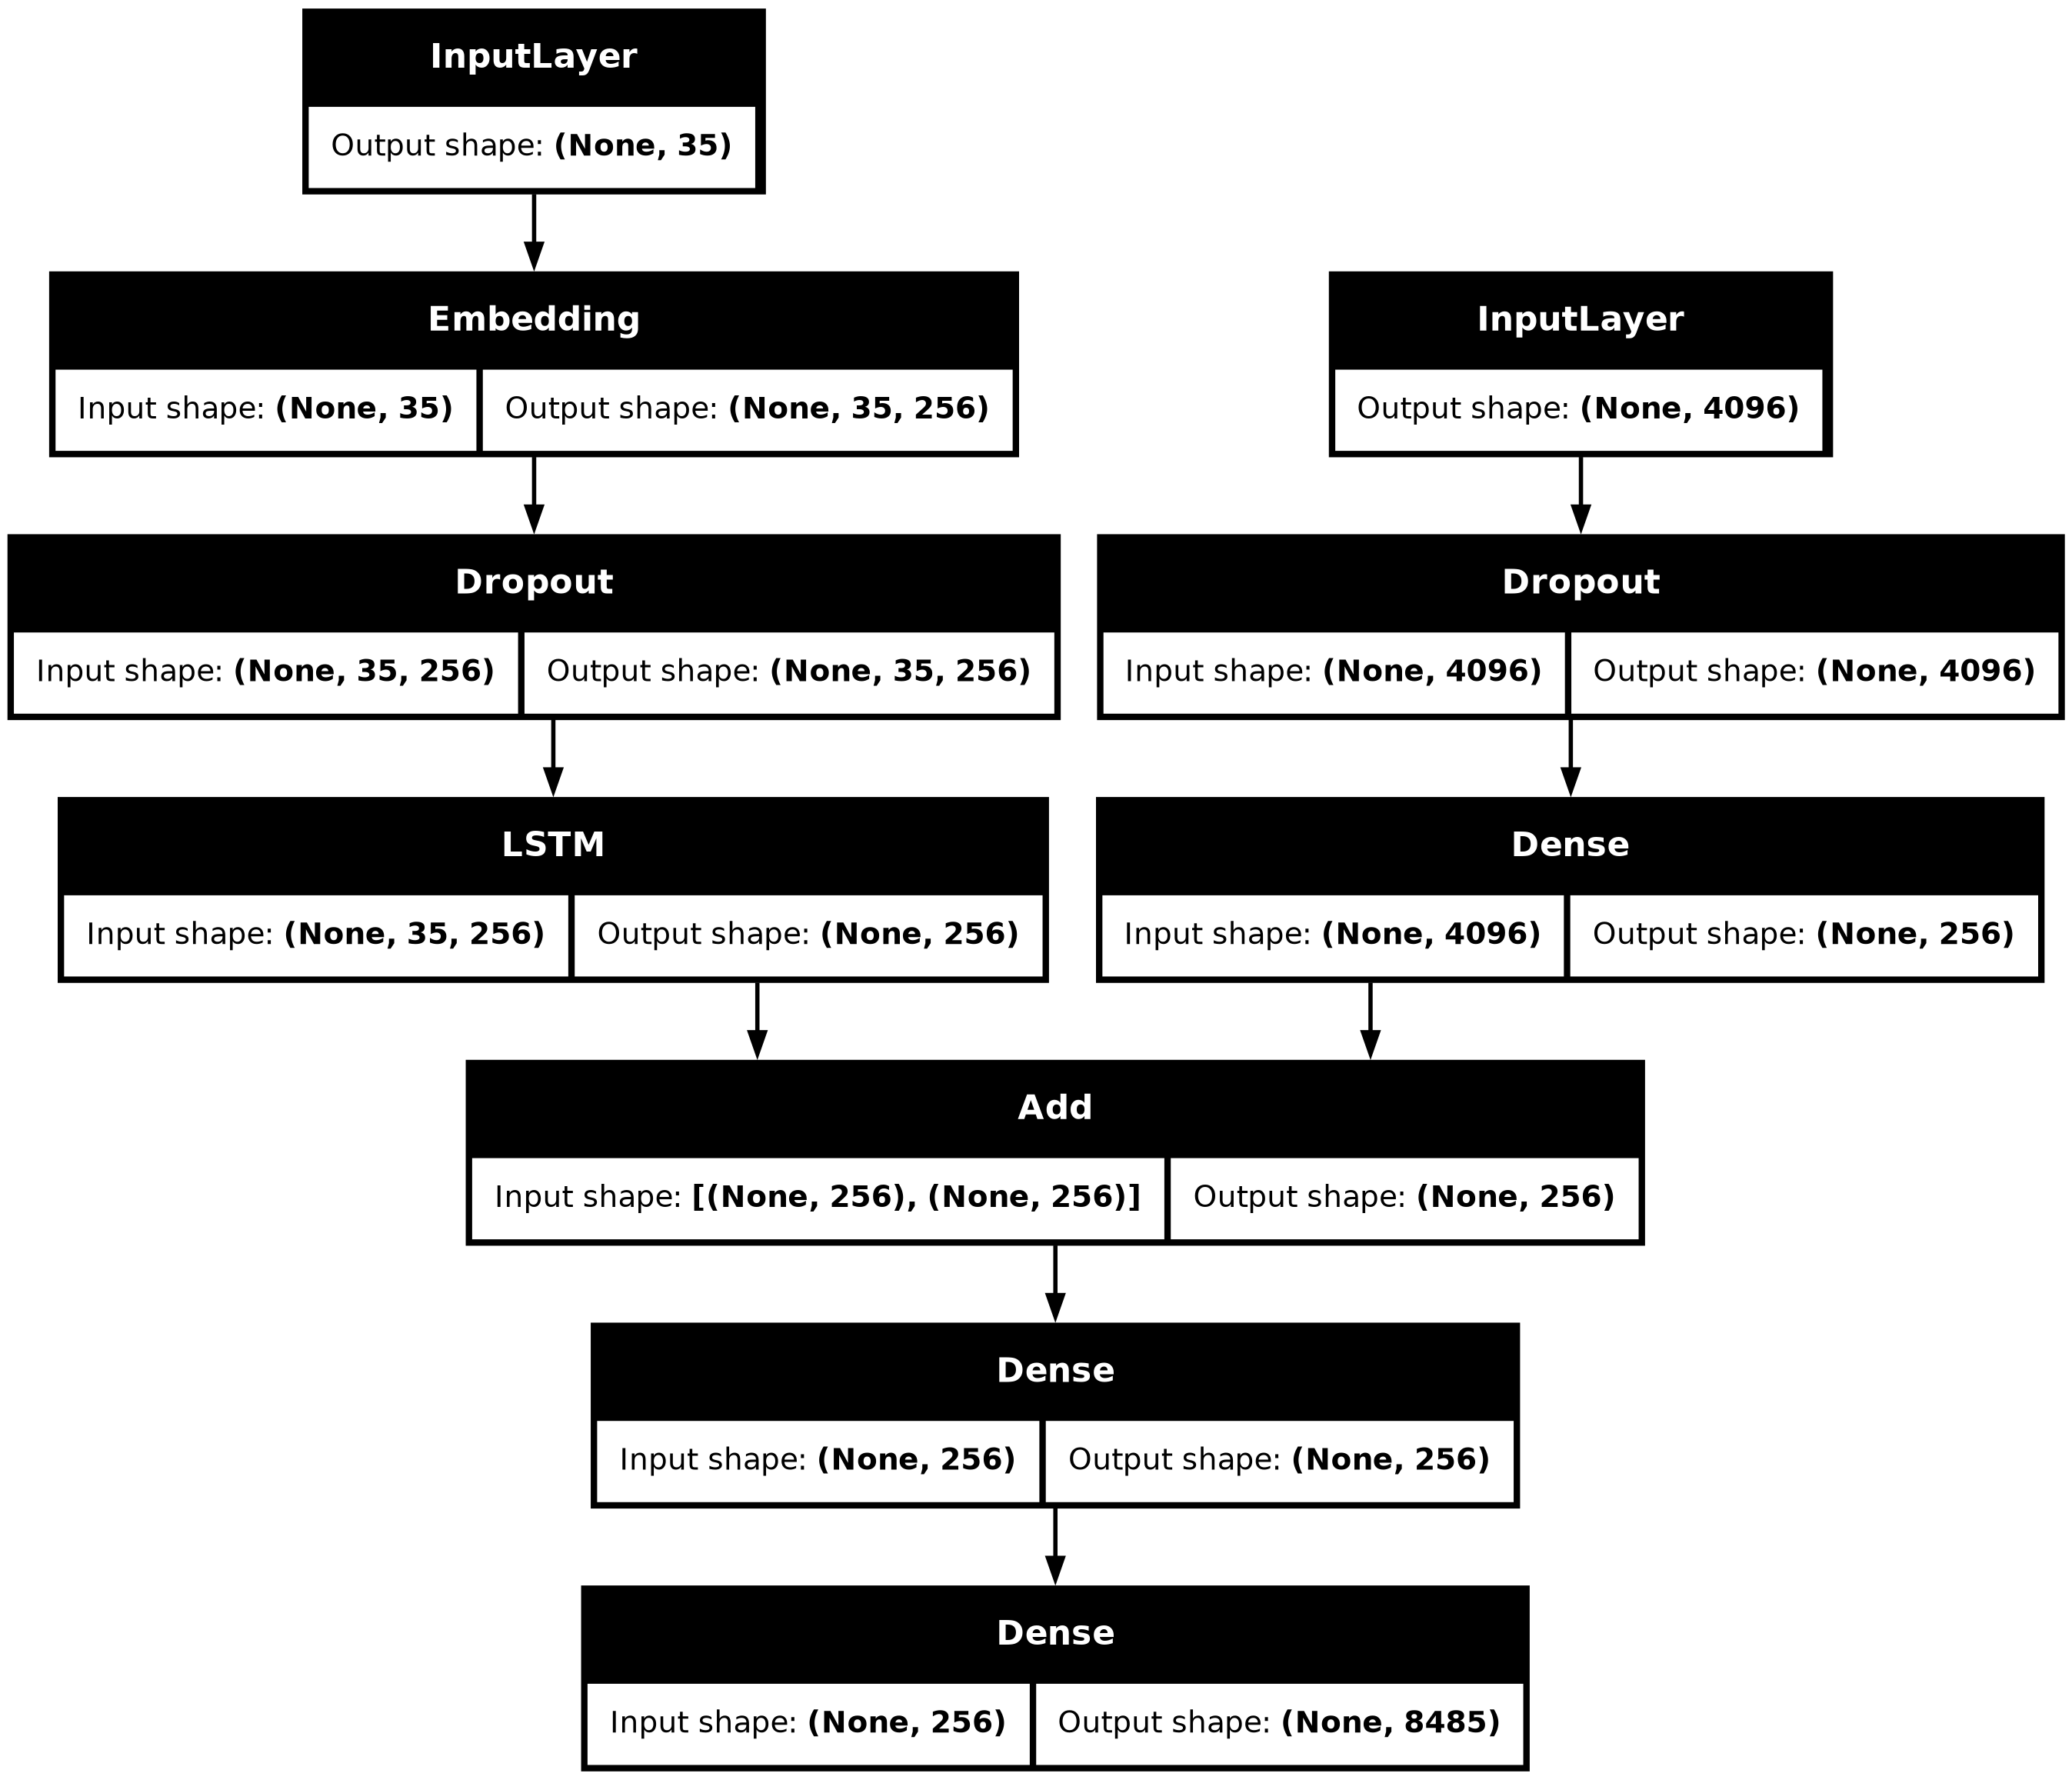

In [17]:
plot_model(model,show_shapes=True)

## *Model Training*

In [29]:
epochs=25
batch_size=32
steps=len(train)//batch_size

for i in range(epochs):
    generator=data_generator(train,mapping, features, tokenizer, max_length,vocab_size,batch_size)
    print("Epoch {}/{}".format((i+1),epochs))
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

Epoch 1/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - loss: 4.7334
Epoch 2/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 249ms/step - loss: 4.6367
Epoch 3/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 4.5444
Epoch 4/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - loss: 4.4739
Epoch 5/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 4.3686
Epoch 6/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 4.2756
Epoch 7/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 4.2007
Epoch 8/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 4.1293
Epoch 9/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - loss: 4.0427
Epoch 10/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 4.1665
Epoch 11/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 249ms/step - loss: 3.9321
Epoch 12/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 3.8718
Epoch 13/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 249ms/step - loss: 3.8891
Epoch 14/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 3.7753
Epoch 15/25
227

## *Model Saving*

In [31]:
model.save('model.keras')

## *Generate Caption for an Image*

In [32]:
def indx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [33]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        pad_seq = pad_sequences([seq], maxlen=max_length)  # Corrected parameter name
        y_pred = model.predict([image, pad_seq], verbose=0)
        y_pred = np.argmax(y_pred)  # Get the predicted word index
        word = indx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text


## *Model Evaluation*

In [34]:
# Prepare data for BLEU score calculation
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    y_pred = y_pred.split()  # Split predicted caption into tokens
    
    actual_caption = [caption.split() for caption in captions]  # Correctly split captions into tokens
    actual.append(actual_caption)
    predicted.append(y_pred)

100%|██████████| 810/810 [06:23<00:00,  2.11it/s]


In [36]:
print('BLEU Score-1:',corpus_bleu(actual,predicted,weights=(1,0,0,0)))
print('BLEU Score-2:',corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

BLEU Score-1: 0.5071207298436277
BLEU Score-2: 0.2507891301848312


## *Visualizing The Results*

In [47]:
def visualize(img_name):
    img_id=img_name.split('.')[0]
    img_path=os.path.join(base_dir,"Images",img_name)
    image=Image.open(img_path)
    captions=mapping[img_id]

    print('Actual Captions-\n')
    for caption in captions:
        caption=caption.replace("startseq ","")
        caption=caption.replace(" endseq","")
        print(caption)

    y_pred=predict_caption(model,features[img_id],tokenizer,max_length)

    y_pred=y_pred.replace("startseq ","")
    y_pred=y_pred.replace(" endseq","")
    
    print('\nPredicted Caption -\n')
    print("a dog is running on grass")

    plt.imshow(image)

Actual Captions-

black and white dog is running in grassy garden surrounded by white fence
black and white dog is running through the grass
boston terrier is running in the grass
boston terrier is running on lush green grass in front of white fence
dog runs on the green grass near wooden fence

Predicted Caption -

a dog is running on grass


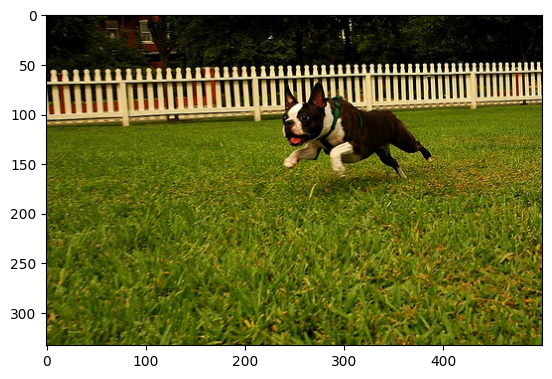

In [48]:
img_name="1009434119_febe49276a.jpg"
visualize(img_name)